In [264]:
from pandas import Series, DataFrame
import pandas as pd
%pylab inline
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from scipy.stats import randint as sp_randint
from time import time
from tabulate import tabulate
from sklearn.metrics import *
from xgboost.sklearn import XGBClassifier
df = pd.read_csv('/Users/ReeceWooten/Documents/School /MSBA/Summer/Predictive analytics /Unsuprivised learning/GitHub/Data-Science-Portfolio/KickStarter Project/kickstarter_final.csv')



Populating the interactive namespace from numpy and matplotlib


## View the first couple of rows

In [265]:
df[:2]

,name,goal,pledged,state,country,deadline,state_changed_at,created_at,launched_at,staff_pick,backers_count,usd_pledged,static_usd_rate,location,category,projectlength,category1,subcategory
0,Racial Reconciliation Music Project,5000.0,262.0,NC,US,1479358740,1479358740,1476729788,1476818224,False,8,262.0,1.0,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",2540516,music,faith
1,Poetic Cultivation,1500.0,0.0,FL,US,1407002463,1407002463,1404240350,1404410463,False,0,0.0,1.0,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",2592000,publishing,poetry


# Pre-Proccessing/Feature Engineering

### Create a successful status column

In [266]:
df.loc[df['goal']<=df['pledged'], 'status'] = 1
df.loc[df['goal']>df['pledged'], 'status']= 0
df['status']=pd.to_numeric(df['status'])


In [267]:
sum(df['status']==1)/(float(sum(df['status']==0)+sum(df['status']==1)))

0.40069861281191654

The positive class is about 40% of the data so there is no need to re-balance the data

### Changing the time stamp to days (currently in seconds)

In [268]:
df['projectlength_days']=(df['projectlength']/(60*60*24))

### Creating a data-frame of unfinished kickstarters

In [269]:
df_not_fin=df[df['deadline']>1500076800]
df_not_fin_0=df_not_fin[df_not_fin['status']==0]

### Difference between creation and launch time

In [270]:
df['time_bw_create_launch']=df['launched_at']-df['created_at']
df['time_bw_create_launch']=(df['time_bw_create_launch']/(60*60*24))


A kickstarter may be more successful if the owner took more time between the creation of the project and the launch of the project

### Kickstarter portion of the pledges

In [271]:
successful=df[df['status']==1]
df['kickstarter_cut']=successful['usd_pledged']*.08

At the time of the project, kickstarter takes about 8% of successfully funded projects

### Summary statistics about the categories 

In [272]:
backers_cat=df[['backers_count','category1']]
backers_cat_stat=backers_cat.groupby('category1').describe()
backers_cat_stat

backers_count                                                    \
                    count        mean          std  min   25%   50%     75%   
category1                                                                     
art                4760.0   41.535714   344.779124  0.0   2.0   9.0   36.00   
comics             1317.0  160.582384   420.104241  0.0  11.0  45.0  138.00   
crafts              957.0   19.137931    62.201436  0.0   1.0   3.0   10.00   
dance               357.0   35.089636    43.581292  0.0   4.0  21.0   51.00   
design             2097.0  440.270386  2033.722392  0.0  13.0  77.0  287.00   
fashion            2736.0   65.642544   313.512828  0.0   1.0   5.0   37.00   
film               7952.0   96.016097  1085.043809  0.0   3.0  21.0   66.00   
food               3156.0   39.154309   111.435261  0.0   1.0   4.0   25.00   
games              3710.0  513.054717  2134.211020  0.0   7.0  73.0  321.75   
journalism          713.0   37.886396   193.149196  0.0   0.0   2.0    8.00   
music              8263.0   52.641293   135.303278  0.0   2.0  22.0   64.00   
photography        1194.0   35.159966   117.585590  0.0   1.0   3.0   20.00   
publishing         5933.0   71.653632   266.193191  0.0   2.0  15.0   62.00   
technology         5736.0  170.767782   833.516306  0.0   1.0   6.0   52.00   
theater             932.0   47.245708   149.829401  0.0   4.0  19.0   50.00   

                      
                 max  
category1             
art          22840.0  
comics        6435.0  
crafts        1069.0  
dance          294.0  
design       62642.0  
fashion       9624.0  
film         91585.0  
food          2165.0  
games        69320.0  
journalism    3116.0  
music         4905.0  
photography   2687.0  
publishing    9044.0  
technology   21412.0  
theater       3722.0

In [273]:
pledged_cat=df[['usd_pledged','category1']]
pledged_cat_stat=pledged_cat.groupby('category1').describe()
pledged_cat_stat

usd_pledged                                                \
                  count          mean            std  min         25%   
category1                                                               
art              4760.0   3042.986386   22210.814856  0.0   28.057971   
comics           1317.0   7879.523307   28808.324656  0.0  325.000000   
crafts            957.0   1297.015515    5327.262964  0.0    1.000000   
dance             357.0   3064.782536    4722.557328  0.0  172.000000   
design           2097.0  44715.658122  374885.522046  0.0  565.000000   
fashion          2736.0   6732.499053   31047.170879  0.0    4.000000   
film             7952.0   8248.146472   68354.262348  0.0   76.000000   
food             3156.0   3807.838668   11059.899267  0.0    2.000000   
games            3710.0  29984.092931  158717.968874  0.0  204.040709   
journalism        713.0   2405.135173   11214.772674  0.0    0.000000   
music            8263.0   3728.466506    9043.800899  0.0   65.000000   
photography      1194.0   2820.270929    8143.555916  0.0    1.000000   
publishing       5933.0   4338.948681   15139.939431  0.0   51.000000   
technology       5736.0  23268.256793  124940.549155  0.0   10.000000   
theater           932.0   4008.423815   10712.375886  0.0  131.619903   

                                                     
                     50%           75%          max  
category1                                            
art           419.100118   2211.500000   1365105.45  
comics       1690.000000   5709.000000    665725.94  
crafts         59.529214    523.000000     86207.00  
dance        1469.400933   4154.000000     46270.09  
design       5230.000000  23569.284659  13285226.36  
fashion       208.500000   3001.000000    654557.00  
film         1505.500000   6213.940000   5702153.38  
food          110.558560   2113.750000    255669.50  
games        3143.687291  15487.798596   6333295.77  
journalism     26.000000    457.740276    171755.09  
music        1194.516738   4352.500000    326593.51  
photography   101.000000   1355.500000    107193.35  
publishing    725.000000   3775.000000    613251.44  
technology    313.150131   5289.250000   3401361.08  
theater      1233.195431   3894.891598    169985.91

# EDA

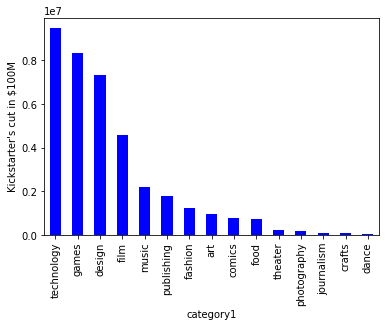

In [274]:
kickstarter_bycat_dollar=df.groupby(['category1'])[['kickstarter_cut','goal']].agg(['mean','count','sum'])
kickstarter_bycat_dollar['kickstarter_cut'].sort_values(by=['sum'],ascending=[False])['sum'].plot(kind='bar',color='blue')
ylabel('Kickstarter\'s cut in $100M')

Kickstarter may be interested in which categories bring in the most money for them, it looks like technology, games, and design bring in the most for kickstarter. This may be due to the number of projects in these categories though.

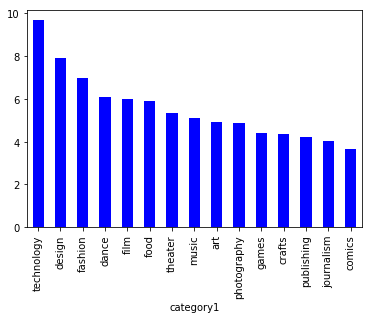

In [275]:
kickstarter_bycat_dollar=df.groupby(['category1'])[['kickstarter_cut','goal','backers_count']].agg(['mean','count','sum'])
(kickstarter_bycat_dollar['kickstarter_cut']['sum']/kickstarter_bycat_dollar['backers_count']['sum']).sort_values(ascending=[False]).plot(kind='bar',color='blue')


This chart takes into account the number of backers per category, this could be used to get a sense of which categories backers support more than others. In contrast to the previous graph games is no longer in the top three which indicates that games backers don’t tend to support projects more than technology and design backers. 


#### Interactions

In [276]:
kickstarter_bycat_dollar=df.groupby(['category1'])[['kickstarter_cut','usd_pledged','backers_count']].agg(['mean','count','sum'])
kickstarter_bycat_success=df.groupby(['category1','status'])[['usd_pledged']].agg(['sum'])
q=kickstarter_bycat_success.unstack()['usd_pledged']['sum']


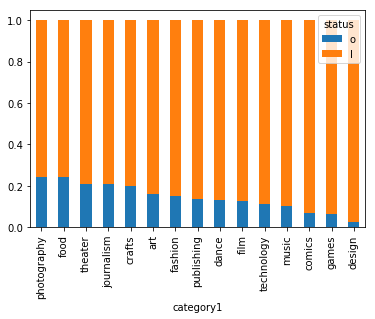

In [277]:
kickstarter_bycat_success=df.groupby(['category1','status'])[['usd_pledged']].agg(['sum'])
kickstarter_bycat_success=kickstarter_bycat_success.unstack()['usd_pledged']['sum']
kickstarter_bycat_success['o']=kickstarter_bycat_success[0]/(kickstarter_bycat_success[0]+kickstarter_bycat_success[1])  
kickstarter_bycat_success['l']=kickstarter_bycat_success[1]/(kickstarter_bycat_success[0]+kickstarter_bycat_success[1])
kickstarter_bycat_success['total_funded']=kickstarter_bycat_success['o']+kickstarter_bycat_success['l']
kickstarter_bycat_success=kickstarter_bycat_success.sort_values(by=['o'],ascending=False)
kickstarter_bycat_success[['o','l']].plot.bar(stacked=True)


There does seem to be a monotonic relationship between category and a project being successfully funded. While these categories aren’t adjusted by the number of projects per category or by goal, it does look like photography and food are more successful on average than games and design. 

In [278]:
kickstarter_bycat_dollar=df.groupby(['category1'])[['kickstarter_cut','usd_pledged','backers_count']].agg(['mean','count','sum'])


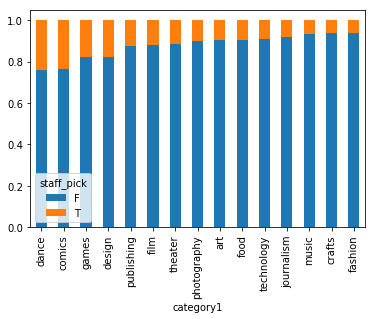

In [279]:
kickstarter_bycat_dollar=df.groupby(['category1','staff_pick'])['name'].agg(['count'])
kickstarter_staff=kickstarter_bycat_dollar.unstack()['count']
kickstarter_staff['total_staff']=kickstarter_staff[False]+kickstarter_staff[True]
kickstarter_staff['F']=kickstarter_staff[False]/(kickstarter_staff[False]+kickstarter_staff[True])
kickstarter_staff['T']=kickstarter_staff[True]/(kickstarter_staff[False]+kickstarter_staff[True])
kickstarter_staff=kickstarter_staff.sort_values(by=['T'],ascending=False)
kickstarter_staff[['F','T']].plot.bar(stacked=True)


This graph was to get a sense of which categories the staff of kickstarter preferred. 

# Modeling 

### Simple Linear

### Logistic

In [280]:
y, X = dmatrices('usd_pledged ~ time_bw_create_launch+projectlength_days+backers_count+staff_pick+category1+country+state+subcategory', data=df, return_type='dataframe')


In [281]:
model = sm.OLS(y, X)       # Set up the model
result = model.fit()       # Fit model (find the intercept and slopes)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:            usd_pledged   R-squared:                       0.624
Model:                            OLS   Adj. R-squared:                  0.619
Method:                 Least Squares   F-statistic:                     121.9
Date:                Wed, 20 Dec 2017   Prob (F-statistic):               0.00
Time:                        17:24:51   Log-Likelihood:            -4.9830e+05
No. Observations:               39874   AIC:                         9.977e+05
Df Residuals:                   39337   BIC:                         1.002e+06
Df Model:                         536                                         
Covariance Type:            nonrobust                                         
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

In [282]:
p_values=result.pvalues
p_values[p_values<=.05]

staff_pick[T.True]                    4.967591e-09
category1[T.design]                   2.081657e-02
category1[T.film]                     1.049360e-04
category1[T.games]                    1.225745e-08
category1[T.journalism]               2.268555e-26
category1[T.technology]               1.237136e-43
state[T.Anhui]                        1.180612e-17
state[T.Bavaria]                      4.458735e-03
state[T.Bremen]                       9.078454e-03
state[T.Brittany]                     1.145189e-04
state[T.Hovedstaden]                  8.786243e-05
state[T.Ljubljana]                    8.940548e-04
state[T.Lodz]                         2.839422e-22
state[T.Midtjylland]                  1.555923e-02
state[T.Phuket]                       1.475025e-06
state[T.Prague]                       5.912120e-16
state[T.Syddanmark]                   1.910633e-02
subcategory[T.apps]                   1.688368e-41
subcategory[T.audio]                  7.135946e-16
subcategory[T.camera%20equipmen

In [283]:
formula = 'status ~ 0+projectlength_days+backers_count+staff_pick+category1+country+state+subcategory'
Y, X = dmatrices(formula, df, return_type='dataframe')
y=Y['status'].values

In [284]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [285]:
model = LogisticRegression()
result = model.fit(X_train, y_train)


In [286]:
prediction_train = model.predict(X_train)
prediction = model.predict(X_test)
print 'Training Accuracy:',metrics.accuracy_score(y_train, prediction_train)
print 'Test Accuracy:',metrics.accuracy_score(y_test, prediction)
print 'Recall',metrics.recall_score(y_test,prediction)

Training Accuracy: 0.840278026585
Test Accuracy: 0.837164590822
Recall 0.700583279326


In [287]:
confusion_matrix(y_test,prediction)

array([[6772,  562],
       [1386, 3243]])

In [288]:
negative_examples_in_test = len(y_test[y_test==0])
total_examples_in_test = len(y_test)

print 'Baseline accuracy =', negative_examples_in_test * 1.0 / total_examples_in_test

Baseline accuracy = 0.61305692552


In [289]:
weights = Series(model.coef_[0],
                 index=X.columns.values)
weights.sort_values()[:5]

country[T.GB]                   -1.881956
subcategory[T.mobile%20games]   -1.221055
subcategory[T.hip]              -1.068824
subcategory[T.architecture]     -0.951407
category1[T.technology]         -0.870659
dtype: float64

In [290]:
weights.sort_values(ascending=False)[:5]

subcategory[T.tabletop%20games]    3.010719
subcategory[T.product%20design]    1.897134
subcategory[T.indie%20rock]        1.107076
country[T.SE]                      1.084520
subcategory[T.rock]                1.057477
dtype: float64

### Logistic (Creators View)

Unfortunately the variables in the logistic regression performed in the previous section aren’t always up to the creator of the kickstarter. To see if we can better predict the success of a kickstarter only variables in the control of kickstarter were considered. 

In [291]:
formula = 'status ~ 0+projectlength_days+goal+category1+country+state+subcategory'
Y, X = dmatrices(formula, df, return_type='dataframe')
y=Y['status'].values

In [292]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


In [293]:
model = LogisticRegression()
result = model.fit(X_train, y_train)


In [294]:
prediction_train = model.predict(X_train)
prediction = model.predict(X_test)
print 'Training Accuracy:',metrics.accuracy_score(y_train, prediction_train)
print 'Test Accuracy:',metrics.accuracy_score(y_test, prediction)

Training Accuracy: 0.610189531009
Test Accuracy: 0.61305692552


There was a significant decline in model accuracy, which is essentially the base line. This indicated that a logistic regression might not be able to predict the success of a project.

In [295]:
model.coef_
weights = Series(model.coef_[0],
                 index=X.columns.values)
print 'negatively correlated variables'
weights.sort_values()[:5]

negatively correlated variables


projectlength_days      -0.008336
country[T.GB]           -0.000147
state[T.England]        -0.000126
category1[technology]   -0.000106
category1[food]         -0.000079
dtype: float64

In [296]:
print 'Positively correlated variables'
weights.sort_values(ascending=False)[:5]

Positively correlated variables


subcategory[T.tabletop%20games]    0.000091
subcategory[T.product%20design]    0.000085
category1[music]                   0.000073
category1[design]                  0.000071
category1[games]                   0.000066
dtype: float64

### Random Forest

Because the previous logistic regression performed poorly, two other modeling techniques were used to see if there could be an improvement in accuracy

In [297]:
t0=time()
parameters = {'n_estimators':sp_randint(50, 500), 'max_depth':sp_randint(10, 50),'criterion':('gini','entropy')}
RF =ensemble.RandomForestClassifier()
random_search = RandomizedSearchCV(RF, param_distributions=parameters,n_iter=20,n_jobs=-1)
result=random_search.fit(X_train,y_train)
print 'Time Taken:',(time()-t0)/60.0

Time Taken: 7.26082086563


In [298]:
print 'Best Model:'
result.best_estimator_

Best Model:


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=33, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=348, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [299]:
RF =ensemble.RandomForestClassifier(n_estimators=350,criterion='gini',max_depth=33,n_jobs=-1)
result=RF.fit(X_train,y_train)

In [300]:
from tabulate import tabulate
headers = ["Feature", "Importance"]
importance_values = sorted(zip(X_train.columns, result.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(importance_values, headers, tablefmt="plain")[:383])

Feature                                Importance
goal                                  0.221185
projectlength_days                    0.155069
subcategory[T.tabletop%20games]       0.0593052
subcategory[T.product%20design]       0.0428296
country[T.GB]                         0.0252844
country[T.US]                         0.019839
state[T.England]                      0.0180187



In [301]:
prediction_train = result.predict(X_train)
prediction = result.predict(X_test)
print 'Training Accuracy:',metrics.accuracy_score(y_train, prediction_train)
print 'Test Accuracy:',metrics.accuracy_score(y_test, prediction)
print 'Recall Score',metrics.recall_score(y_test,prediction)

Training Accuracy: 0.841711153309
Test Accuracy: 0.733846025245
Recall Score 0.49362713329


There was a significant improvement in accuracy using a 'creators' perspective. However the model was only able to predict 50% of the positive class.

In [302]:
confusion_matrix(y_true=y_test,y_pred=prediction)

array([[6494,  840],
       [2344, 2285]])

### Boosting

##### XGBoost needs specific pre-processing on column names

In [303]:
# create a list of numbers from 0 to the length of the columns names
header_list=pd.DataFrame((range(0,len(list(X_train)))))
header_list=header_list.astype(str)
header_list=header_list.transpose()

In [304]:
header=header_list.iloc[0]

In [305]:
from xgboost.sklearn import XGBClassifier

In [306]:
# Save the Column names to combine later
column_names=pd.DataFrame(X_train.columns).transpose()
column_names=column_names.iloc[0]

In [307]:
# Reset the column names
X_train.columns=header
X_test.columns=header

#### Train the model

In [308]:
t0=time()
parameters = {'n_estimators':sp_randint(50,500),'max_depth':sp_randint(2,15)}
xgb=XGBClassifier(objective='binary:logistic')
random_search2 = RandomizedSearchCV(xgb, param_distributions=parameters,n_iter=10,n_jobs=-1)
result2=random_search2.fit(X_train,y_train.astype(int))
print 'Time Taken:',(time()-t0)/60.0

Time Taken: 16.936458683


In [309]:
print 'Best Model:'
result2.best_estimator_

Best Model:


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=486, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [310]:
GB =XGBClassifier(n_estimators=490,objective='binary:logistic',max_depth=2)
result_GB=GB.fit(X_train,y_train)

In [311]:
from tabulate import tabulate
headers = ["Feature", "Importance"]
importance_values = sorted(zip(column_names, result_GB.feature_importances_), key=lambda x: x[1] * -1)
print(tabulate(importance_values, headers, tablefmt="plain")[:384])

Feature                                Importance
goal                                  0.276596
projectlength_days                    0.203515
state[T.CA]                           0.0228955
country[T.US]                         0.0222017
country[T.GB]                         0.0191952
state[T.NY]                           0.0148011
subcategory[T.product%20design]       0.0117946



In [312]:
prediction_train_GB = result_GB.predict(X_train)
prediction_GB = result_GB.predict(X_test)
print 'Training Accuracy:',metrics.accuracy_score(y_train, prediction_train_GB)
print 'Test Accuracy:',metrics.accuracy_score(y_test, prediction_GB)
print 'Recall Score:',metrics.recall_score(y_test,prediction_GB)

Training Accuracy: 0.76414316936
Test Accuracy: 0.743375407506
Recall Score: 0.576798444588


The XGBoost out performed both the Random Forest and logistic regression, with further hyper parameter tuning a better accuracy could be achieved

In [313]:
confusion_matrix(y_true=y_test,y_pred=prediction_GB)

array([[6223, 1111],
       [1959, 2670]])

### Given more time/computational power Hyper-parameter tuning would be performed more robustly


In [ ]:
cv_repeat=RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1)

In [ ]:
t0=time()
parameters = {'n_estimators':sp_randint(50, 500), 'max_depth':sp_randint(10, 50),'criterion':('gini','entropy')}
RF =ensemble.RandomForestClassifier()
random_search = RandomizedSearchCV(RF, param_distributions=parameters,n_iter=10,cv=cv_repeat,n_jobs=-1)
result=random_search.fit(X,y)
print 'Time Taken:',time()-t0
result.best_estimator_

In [ ]:
prediction_train = model.predict(X_train)
prediction = model.predict(X_test)
print 'Training Accuracy:',metrics.accuracy_score(y_train, prediction_train)
print 'Test Accuracy:',metrics.accuracy_score(y_test, prediction)